# Librerías

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import json
import os
import random
import time

from urllib.request import Request, urlopen, urlretrieve
from typing import List
from pprint import pprint
from PIL import Image
from typing_extensions import Required
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.data.dataset import random_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM

# Extracción de datos con web scrapping


In [2]:
# son 905, pero los últimos no tienen data
max_pokemon: int = 898

In [3]:
types = ["grass", "fire", "water", "electric"]

In [4]:
dir1: str = "official-artwork"
if os.path.exists(dir1) == False:
    os.mkdir(dir1)

In [5]:
dir2: str = "all"
if os.path.exists(dir2) == False:
    os.mkdir(dir2)

In [6]:
""" 
SOLO PARA DESCARGAR DATOS
"""
# for pokemon_id in range(max_pokemon):
#     req: Request = Request("https://pokeapi.co/api/v2/pokemon/"+str(pokemon_id+1), 
#                     headers={'User-Agent': 'Mozilla/5.0'})
#     webpage: bytes = urlopen(req).read()
#     json_obj: dict = json.loads(webpage)
#     img_url: str = json_obj["sprites"]["other"]["official-artwork"]["front_default"]
    
#     name: str = json_obj["species"]["name"]
#     type: str = json_obj["types"][0]["type"]["name"]

#     if os.path.exists(dir1+"/"+type) == False:
#         os.mkdir(dir1+"/"+type)
    
#     img: str = img_url.split("/")[-1]
#     urlretrieve(img_url, dir1+"/"+type+"/"+name+".png")

' \nSOLO PARA DESCARGAR DATOS\n'

In [7]:
imgs_category: list = ["official-artwork", "home", "dream_world"]

In [8]:
for type in types:
    if os.path.exists(dir2+"/"+type) == False:
        os.mkdir(dir2+"/"+type)
    # if os.path.exists("svg/"+type) == False:
    #     os.mkdir("svg/"+type)

In [9]:
""" 
SOLO PARA DESCARGAR DATOS
"""
# for pokemon_id in range(max_pokemon):
#     print(pokemon_id+1)
#     req: Request = Request("https://pokeapi.co/api/v2/pokemon/"+str(pokemon_id+1), 
#                     headers={'User-Agent': 'Mozilla/5.0'})
#     webpage: bytes = urlopen(req).read()
#     json_obj: dict = json.loads(webpage)
#     type: str = json_obj["types"][0]["type"]["name"]
#     if type not in types:
#         continue
#     name: str = json_obj["species"]["name"]

#     for img_category in imgs_category:
#         img_url: str = json_obj["sprites"]["other"][img_category]["front_default"]
#         if img_url == None:
#             continue
#         save_route: str = "/"+type+"/"+name+"_"+img_category+"."
#         format: str = img_url[-3:]
#         if format == "svg":
#             urlretrieve(img_url, "svg"+save_route+format)
#             drawing = svg2rlg("svg"+save_route+format)
#             renderPM.drawToFile(drawing, dir2+save_route+"png", fmt="PNG")
#         else:
#             urlretrieve(img_url, dir2+save_route+format)

' \nSOLO PARA DESCARGAR DATOS\n'

In [10]:
# Distribución de los datos
for type in types:
    print(type, len(os.listdir(dir1+"/"+type)))
# types.remove("flying")
print(types)


grass 86
fire 58
water 123
electric 49
['grass', 'fire', 'water', 'electric']


In [11]:
# Distribución de los datos
sum: int = 0
for type in types:
    freq: int = len(os.listdir(dir2+"/"+type))
    sum += freq
    print(type, freq)
# types.remove("flying")
print(sum)

grass 233
fire 155
water 346
electric 131
865


# CNN

## Alexnet

In [12]:
model = torchvision.models.alexnet(pretrained=True)
for e  in model.parameters():
   e.requires_grad = False
model.classifier[4] = nn.Linear(4096, 1024)
model.classifier[6] = nn.Linear(1024, len(types))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(model)

c:\Users\Diego\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Diego\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [13]:
x: List[str] = []
y: List[str] = []
for type in types:
    pokemon_imgs: List[str] = os.listdir(dir2+"/"+type)
    for pokemon_img in pokemon_imgs:
        x.append(dir2+"/"+type+"/"+pokemon_img)
        y.append(type)

In [14]:
class MyDataset(Dataset):
      def __init__(self, list_IDs, labels):
            self.labels = labels
            self.list_IDs = list_IDs

      def __len__(self):
            return len(self.list_IDs)

      def __getitem__(self, index):
            # Select sample
            ID = self.list_IDs[index]

            # Load data and get label
            input_image = Image.open(ID)
            input_image = input_image.convert('RGB')
            preprocess = transforms.Compose([
                  transforms.Resize(256),
                  transforms.CenterCrop(224),
                  transforms.ToTensor()
            ])
            X = preprocess(input_image)
            y = self.labels[index]
            return X, y

In [15]:
le = preprocessing.LabelEncoder()
tensor_y = le.fit_transform(y)
tensor_y = torch.as_tensor(tensor_y)
dataset = MyDataset(x, tensor_y)


In [16]:
data_train, data_val, data_test = random_split(dataset=dataset, lengths=[605, 87, 173])

In [17]:
batch_size = 64
train_loader = DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=data_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=data_test, batch_size=batch_size, shuffle=False)

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.005, weight_decay=0.005, momentum=0.9)
# optimizer = optim.SGD(model.parameters(), lr=0.005)
total_step = len(train_loader)
num_epochs = 100

In [19]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [20]:
def train(model, optimizer, loss_fn, num_epochs) -> List[float]:
  # train the model
  total_step: int = len(train_loader)
  print(total_step)

  list_loss: List[float] = []

  beg = time.time()
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      # forward 
      output = model(images)
      loss   = loss_fn(output, labels)
      # change the params
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
              
      # if (i+1) % 100 == 0:
        # print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        #       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    list_loss.append(loss.item())
    print ('Epoch [{}/{}], Loss: {:.4f}' 
          .format(epoch+1, num_epochs, loss.item()))
  end = time.time()
  print('Finished training trainset in {} seconds'.format(round(end-beg, 2)))

  return list_loss

In [21]:
def validate(model, loss_fn):
    model.eval()
    res = {
        "loss_val": [],
        "acc": []
    }
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        res["loss_val"].append(loss.detach().cpu().data.numpy())
        res["acc"].append(acc)
    return res


In [22]:
def train2(model, optimizer, loss_fn, num_epochs) -> List[float]:
  # train the model
  total_step: int = len(train_loader)
  print(total_step)
  log = []
  beg = time.time()
  for epoch in range(num_epochs):
    model.train()
    list_loss: List[float] = []
    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      # forward 
      output = model(images)
      loss   = loss_fn(output, labels)
      list_loss.append(loss)
      # change the params
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    result = validate(model, loss_fn)
    result['loss_train'] = torch.stack(list_loss).mean().item
    result['loss_train'] = result['loss_train'].cpu().data.numpy()
    log.append(result)
    print(result)
    # list_loss.append(loss.item())
    print ('Epoch [{}/{}], Train loss: {:.4f}, Val loss: {:.4f}, Accuracy: {:.4f}' 
          .format(epoch+1, num_epochs, result['loss_train'], result['loss_val'], result['acc']))
  end = time.time()
  print('Finished training trainset in {} seconds'.format(round(end-beg, 2)))

  return log

In [23]:
def test(model):
    with torch.no_grad():
        correct: int = 0
        total: int = 0
        all_predicted: list = []
        all_labels: list = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predicted.extend((predicted).tolist())
            all_labels.extend((labels).tolist())
        accuracy: float = 100*correct/total
        val = (np.unique(le.inverse_transform(all_predicted)))
        matrix = confusion_matrix(all_labels, all_predicted)
        df = pd.DataFrame(matrix, index=val, columns=val)
        sns.heatmap(df, annot=True, cbar=None, cmap="Greens")
        plt.title("Confusion Matrix"), plt.tight_layout()
        plt.xlabel("Predicted")
        plt.ylabel("Real")
        plt.show()
        print('Test accuracy of the model on the {} test images: {} %'.format(len(data_test), round(accuracy, 2)))


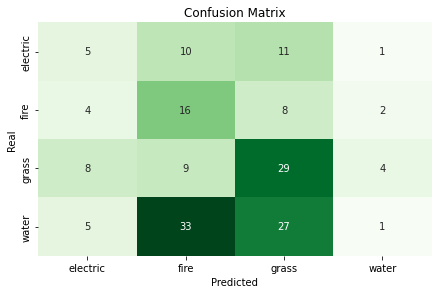

Test accuracy of the model on the 173 test images: 29.48 %


In [24]:
# test before train
test(model)

In [25]:
loss = train(model, optimizer, loss_fn, 10)

10
Epoch [1/10], Loss: 1.4784
Epoch [2/10], Loss: 0.9472
Epoch [3/10], Loss: 0.7834
Epoch [4/10], Loss: 0.5235
Epoch [5/10], Loss: 0.6311
Epoch [6/10], Loss: 0.4964
Epoch [7/10], Loss: 0.4928
Epoch [8/10], Loss: 0.3609
Epoch [9/10], Loss: 0.3635
Epoch [10/10], Loss: 0.2452
Finished training trainset in 30.26 seconds


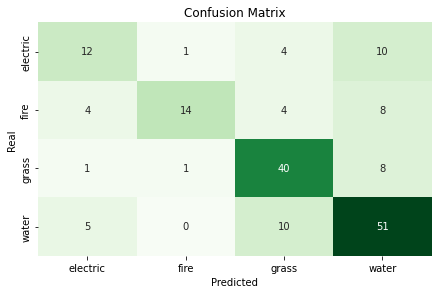

Test accuracy of the model on the 173 test images: 67.63 %


In [26]:
# test after train
torch.manual_seed(1)
test(model)

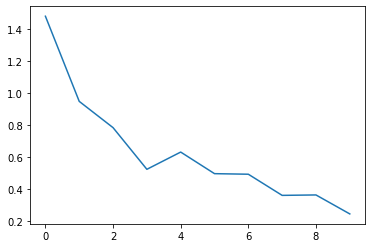

In [27]:
plt.plot(loss)

# Resnet

In [ ]:
# resnet50 = torchvision.models.resnet50(pretrained=True)
# for e in resnet50.parameters():
#    e.requires_grad = False
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# resnet50.fc = nn.Linear(in_features=2048, out_features=len(types), bias=True)
# resnet50.to(device)
# # Adaptar el classifier a las clases
# optimizer = optim.Adam(resnet50.parameters(), lr=3e-4)
# # optimizer = torch.optim.SGD(resnet50.parameters(), lr=0.01, weight_decay = 0.005, momentum = 0.9)  
# loss_arr = train(resnet50, optimizer, loss_fn, 100)